In [1]:
# We create feather file format to investigate if it speeds up data loading
import numpy as np
import pandas as pd
import feather
path = 'data/nyc_od.csv'
OD = pd.read_csv(path, header=None, dtype=np.float64)
path = 'data/nyc_od.feather'
feather.write_dataframe(OD, path)

## Baseline Code

In [2]:
%load_ext line_profiler

In [105]:
import numpy as np
from tqdm import tqdm
import argparse
from multiprocessing import cpu_count
from functools import partial
from multiprocessing.pool import Pool
import pandas as pd

# Matplotlib doesn't play nicely with multiprocessing, so
# we have to create a separate graphing function & import matplotlib inside of that.
def graphing_function(args, days, norms):
    import matplotlib.pyplot as plt
    susceptible_pop_norm, infected_pop_norm, recovered_pop_norm = norms
    public_trans_vec = np.asarray([float(i.replace('[', '').replace(',','').replace(']','')) for i in args.public_trans_vec if i!=']'])
    # plot results and save the plot
    fig = plt.figure()
    ax = plt.axes()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.plot(np.arange(days), susceptible_pop_norm, label='Susceptible', color='#4aa5f0', linewidth=2)
    ax.plot(np.arange(days), infected_pop_norm, label='Infected', color='#f03737', linewidth=2)
    ax.plot(np.arange(days), recovered_pop_norm, label='Recovered', color='#82e88a', linewidth=2)
    ax.plot(np.arange(days), public_trans_vec, '--', label='Transit', color='k', linewidth=2)
    ax.legend(frameon=False)
    ax.set_xlabel("Days")
    ax.set_ylabel("Share of Population")
    if 'fig_name' in args:
        ax.figure.savefig('figures/' + args.fig_name + '.png')
    else:
        ax.figure.savefig('figures/sir_plot.png')
    plt.close()
    
# Convenience function: access Python dict keys as dict.key instead of dict['key']
class objdict(dict):
    def __getattr__(self, name):
        if name in self:
            return self[name]
        else:
            raise AttributeError("No such attribute: " + name)

    def __setattr__(self, name, value):
        self[name] = value

    def __delattr__(self, name):
        if name in self:
            del self[name]
        else:
            raise AttributeError("No such attribute: " + name)
            
# Run n simulations in parallel: for each run, parameters are randomly sampled from an interval
# NOTE: Are these intervals reasonable?
def multiprocess(args):

    chunks = []
    num_procs = args.randomize
    for _ in range(num_procs):
        d = dict()
        d['origin_matrix_path'] = args.origin_matrix_path
        d['thresh1'] = np.random.randint(0, 350)
        d['thresh2'] = np.random.randint(d['thresh1'], 700)
        d['infection_magnitude'] = np.random.randint(5, 15)
        d['beta'] = args.beta
        d['gamma'] = args.gamma
        d['public_trans'] = np.random.randint(1, 7) * 0.1
        d['public_trans_vec'] = np.asarray([float(i.replace('[', '').replace(',','').replace(']','')) for i in args.public_trans_vec if i!=']'])
        d['days'] = args.days
        d['fig_name'] = 'public_trans_{:0.1f}_({}, {})_inf_{}'.format(d['public_trans'], d['thresh1'], d['thresh2'], d['infection_magnitude'])
        d['loading'] = args.loading
        d = objdict(d)
        chunks.append(d)

    with Pool(num_procs) as p:
        p.map(covid_sim, chunks)

    p.join()

def covid_sim(args):
    # Read in origin-destination flow matrix
    if int(args.loading) == 0:
        OD = np.genfromtxt(args.origin_matrix_path, delimiter=',')
        
    elif int(args.loading) == 1:
        OD = pd.read_csv('data/nyc_od.csv', header=None, dtype=np.float64).to_numpy()
        
    elif int(args.loading) == 2:
        OD = feather.read_dataframe('data/nyc_od.feather').to_numpy()
    

    # initialize the population vector from the origin-destination flow matrix
    N_k = np.abs(np.diagonal(OD) + OD.sum(axis=0) - OD.sum(axis=1))
    locs_len = len(N_k)                 # number of locations
    SIR = np.zeros(shape=(locs_len, 3)) # make a numpy array with 3 columns for keeping track of the S, I, R groups
    SIR[:,0] = N_k                      # initialize the S group with the respective populations
    thresh1 = args.thresh1
    thresh2 = args.thresh2

    first_infections = np.where((thresh1 <= SIR[:, 0]) & (SIR[:, 0] <= thresh2), np.random.randint(1, args.infection_magnitude), 0)   # for demo purposes, randomly introduce infections
    # NOTE: this is arbitrary but not actually random.... 
    SIR[:, 0] = SIR[:, 0] - first_infections
    SIR[:, 1] = SIR[:, 1] + first_infections                           # move infections to the I group

    # row normalize the SIR matrix for keeping track of group proportions
    row_sums = SIR.sum(axis=1)
    SIR_n = SIR / row_sums[:, np.newaxis]

    # initialize parameters
    beta = args.beta
    gamma = args.gamma
    public_trans = args.public_trans                                 # alpha
    R0 = beta/gamma
    beta_vec = np.random.gamma(beta, 2, locs_len)
    gamma_vec = np.full(locs_len, gamma)
    public_trans_vec = args.public_trans_vec
    if isinstance(public_trans_vec[0], str):
        public_trans_vec = np.asarray([float(i.replace('[', '').replace(',','').replace(']','')) for i in public_trans_vec if i!=']'])

    # make copy of the SIR matrices 
    SIR_sim = SIR.copy()
    SIR_nsim = SIR_n.copy()

    # run model
    #print(SIR_sim.sum(axis=0).sum() == N_k.sum())
    infected_pop_norm = []
    susceptible_pop_norm = []
    recovered_pop_norm = []
    days = args.days
    for time_step in tqdm(range(days)):
        infected_mat = np.array([SIR_nsim[:,1],]*locs_len).transpose()
        OD_infected = np.round(OD*infected_mat)
        inflow_infected = OD_infected.sum(axis=0)
        inflow_infected = np.round(inflow_infected*public_trans_vec[time_step])
        #print('total infected inflow: ', inflow_infected.sum())
        new_infect = beta_vec*SIR_sim[:, 0]*inflow_infected/(N_k + OD.sum(axis=0))
        new_recovered = gamma_vec*SIR_sim[:, 1]
        new_infect = np.where(new_infect>SIR_sim[:, 0], SIR_sim[:, 0], new_infect)
        SIR_sim[:, 0] = SIR_sim[:, 0] - new_infect
        SIR_sim[:, 1] = SIR_sim[:, 1] + new_infect - new_recovered
        SIR_sim[:, 2] = SIR_sim[:, 2] + new_recovered
        SIR_sim = np.where(SIR_sim<0,0,SIR_sim)
        # recompute the normalized SIR matrix
        row_sums = SIR_sim.sum(axis=1)
        SIR_nsim = SIR_sim / row_sums[:, np.newaxis]
        S = SIR_sim[:,0].sum()/N_k.sum()
        I = SIR_sim[:,1].sum()/N_k.sum()
        R = SIR_sim[:,2].sum()/N_k.sum()
        #print(S, I, R, (S+I+R)*N_k.sum(), N_k.sum())
        #print('\n')
        infected_pop_norm.append(I)
        susceptible_pop_norm.append(S)
        recovered_pop_norm.append(R)

    graphing_function(args, days, (susceptible_pop_norm, infected_pop_norm, recovered_pop_norm))

def covid_sim_serial(args):
    for i in range(args.randomize):
        covid_sim(args)

In [12]:
parser = argparse.ArgumentParser(description='COVID Simulator')
parser.add_argument('--randomize', type=int, default=0)
parser.add_argument('--origin-matrix-path', default='data/nyc_od.csv')
parser.add_argument('--thresh1', type=int, default=0)
parser.add_argument('--thresh2', type=int, default=100)
parser.add_argument('--infection-magnitude', type=int, default=10)
parser.add_argument('--beta', type=float, default=0.75)
parser.add_argument('--gamma', type=float, default=0.2)
parser.add_argument('--public-trans', type=float, default=0.5)
parser.add_argument('--public-trans-vec', nargs='+', default=[])
parser.add_argument('--days', type=int, default=100)
parser.add_argument('--img-folder', default='figures/')
parser.add_argument('--loading', default = 0)

_StoreAction(option_strings=['--loading'], dest='loading', nargs=None, const=None, default=0, type=None, choices=None, help=None, metavar=None)

In [26]:
# ptv = [0.56      , 0.56      , 0.56      , 0.56      , 0.56      ,
#        0.56      , 0.56      , 0.56      , 0.56      , 0.56      ,
#        0.56      , 0.56      , 0.56      , 0.56      , 0.56      ,
#        0.56      , 0.56      , 0.56      , 0.56      , 0.5264    ,
#        0.4928    , 0.4592    , 0.4256    , 0.392     , 0.3584    ,
#        0.3248    , 0.2912    , 0.2576    , 0.224     , 0.21585455,
#        0.20770909, 0.19956364, 0.19141818, 0.18327273, 0.17512727,
#        0.16698182, 0.15883636, 0.15069091, 0.14254545, 0.1344    ,
#        0.12625455, 0.11810909, 0.10996364, 0.10181818, 0.09367273,
#        0.08552727, 0.07738182, 0.06923636, 0.06109091, 0.05294545,
#        0.0448    , 0.04417778, 0.04355556, 0.04293333, 0.04231111,
#        0.04168889, 0.04106667, 0.04044444, 0.03982222, 0.0392    ,
#        0.0392    , 0.0392    , 0.0392    , 0.0392    , 0.0392    ,
#        0.0392    , 0.0392    , 0.0392    , 0.0392    , 0.0392    ,
#        0.0392    , 0.0392    , 0.0392    , 0.0392    , 0.0392    ,
#        0.0392    , 0.0392    , 0.0392    , 0.0392    , 0.0392    ,
#        0.0392    , 0.0392    , 0.0392    , 0.0392    , 0.0392    ,
#        0.0392    , 0.0392    , 0.0392    , 0.0392    , 0.0392    ,
#        0.0392    , 0.0392    , 0.0392    , 0.0392    , 0.0392    ,
#        0.0392    , 0.0392    , 0.0392    , 0.0392    , 0.0392    ]
ptv = np.full(100, 0.56)

In [6]:
args1 = parser.parse_args(f'--randomize 4 --gamma 0.2 --days 100 --loading 0 --public-trans-vec {ptv}'.split())

### Line Profiler Analysis

Using lprun, we see that most of the time is spent loading in the Origin-Destination flow matrix (accounts for 39.2% of the time) and computing the element-wise matrix multiplication OD\*infected_mat and rounding it (accounts for 43.8% of the time). Note that the matrix multiplication occurs in a for-loop that runs multiple times while the loading of the matrix occurs only once. The percentage of time needed to perform all of the matrix multiplications at all of the time steps is roughly the same as the time needed to load in the matrix. We will first focus on trying read the OD matrix faster.

In [51]:
%lprun -f multiprocess multiprocess(args1)

100%|██████████| 100/100 [00:24<00:00,  4.05it/s]


Timer unit: 1e-06 s

Total time: 41.6815 s
File: <ipython-input-47-8c4548d6adc3>
Function: multiprocess at line 53

Line #      Hits         Time  Per Hit   % Time  Line Contents
    53                                           def multiprocess(args):
    54                                           
    55         1          3.0      3.0      0.0      chunks = []
    56         1          3.0      3.0      0.0      num_procs = args.randomize
    57         5          8.0      1.6      0.0      for _ in range(num_procs):
    58         4          5.0      1.2      0.0          d = dict()
    59         4          5.0      1.2      0.0          d['origin_matrix_path'] = args.origin_matrix_path
    60         4        135.0     33.8      0.0          d['thresh1'] = np.random.randint(0, 350)
    61         4         18.0      4.5      0.0          d['thresh2'] = np.random.randint(d['thresh1'], 700)
    62         4         16.0      4.0      0.0          d['infection_magnitude'] = np.rand

In [7]:
%lprun -f covid_sim covid_sim(args1)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:23<00:00,  4.31it/s]


Timer unit: 1e-07 s

Total time: 29.3087 s
File: <ipython-input-3-15fe1c642843>
Function: covid_sim at line 78

Line #      Hits         Time  Per Hit   % Time  Line Contents
    78                                           def covid_sim(args):
    79                                               # Read in origin-destination flow matrix
    80         1         36.0     36.0      0.0      if int(args.loading) == 0:
    81         1   57828114.0 57828114.0     19.7          OD = np.genfromtxt(args.origin_matrix_path, delimiter=',')
    82                                                   
    83                                               elif int(args.loading) == 1:
    84                                                   OD = pd.read_csv('data/nyc_od.csv', header=None, dtype=np.float64).to_numpy()
    85                                                   
    86                                               elif int(args.loading) == 2:
    87                                          

We try data loading using pandas, given by loading argument value of 1 and feather, given by loading argument value of 2.

In [15]:
args2 = parser.parse_args(f'--randomize 4 --gamma 0.2 --days 100 --public-trans-vec {ptv} --loading 1'.split())

In [16]:
args3 = parser.parse_args(f'--randomize 4 --gamma 0.2 --days 100 --public-trans-vec {ptv} --loading 2'.split())

In [10]:
%lprun -f covid_sim_serial covid_sim_serial(args1)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.57it/s]


Timer unit: 1e-07 s

Total time: 113.491 s
File: <ipython-input-3-15fe1c642843>
Function: covid_sim_serial at line 155

Line #      Hits         Time  Per Hit   % Time  Line Contents
   155                                           def covid_sim_serial(args):
   156         5        149.0     29.8      0.0      for i in range(args.randomize):
   157         4 1134912578.0 283728144.5    100.0          covid_sim(args)

In [17]:
%lprun -f covid_sim_serial covid_sim_serial(args2)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.87it/s]

Timer unit: 1e-07 s

Total time: 85.3714 s
File: <ipython-input-3-15fe1c642843>
Function: covid_sim_serial at line 155

Line #      Hits         Time  Per Hit   % Time  Line Contents
   155                                           def covid_sim_serial(args):
   156         5        146.0     29.2      0.0      for i in range(args.randomize):
   157         4  853714347.0 213428586.8    100.0          covid_sim(args)

In [18]:
%lprun -f covid_sim_serial covid_sim_serial(args3)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.86it/s]


Timer unit: 1e-07 s

Total time: 82.4685 s
File: <ipython-input-3-15fe1c642843>
Function: covid_sim_serial at line 155

Line #      Hits         Time  Per Hit   % Time  Line Contents
   155                                           def covid_sim_serial(args):
   156         5        157.0     31.4      0.0      for i in range(args.randomize):
   157         4  824685341.0 206171335.2    100.0          covid_sim(args)

In [37]:
%lprun -f multiprocess multiprocess(args1)

100%|██████████| 100/100 [00:20<00:00,  4.99it/s]


Timer unit: 1e-06 s

Total time: 32.0098 s
File: <ipython-input-33-13ea8e705494>
Function: multiprocess at line 53

Line #      Hits         Time  Per Hit   % Time  Line Contents
    53                                           def multiprocess(args):
    54                                           
    55         1          4.0      4.0      0.0      chunks = []
    56         1          4.0      4.0      0.0      num_procs = args.randomize
    57         5         21.0      4.2      0.0      for _ in range(num_procs):
    58         4         10.0      2.5      0.0          d = dict()
    59         4          9.0      2.2      0.0          d['origin_matrix_path'] = args.origin_matrix_path
    60         4        133.0     33.2      0.0          d['thresh1'] = np.random.randint(0, 350)
    61         4         55.0     13.8      0.0          d['thresh2'] = np.random.randint(d['thresh1'], 700)
    62         4         33.0      8.2      0.0          d['infection_magnitude'] = np.rand

In [212]:
%lprun -f multiprocess multiprocess(args2)

100%|██████████| 100/100 [00:10<00:00,  9.71it/s]


In [213]:
%lprun -f multiprocess multiprocess(args3)

100%|██████████| 100/100 [00:10<00:00, 10.26it/s]

100%|██████████| 100/100 [00:10<00:00, 10.45it/s]


We find that loading data with feather works the fastest, so we'll be using that going forward.

### Improving Matrix Multiplication using Cython

We want to investigate if using Cython can provide a greater speedup.

In [76]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [111]:
%%cython

# cython: profile=True
# cython: linetrace=True
# cython: binding=True
# distutils: define_macros=CYTHON_TRACE_NOGIL=1

import numpy as np
from tqdm import tqdm
import argparse
from multiprocessing import cpu_count
from functools import partial
from multiprocessing.pool import Pool
import pandas as pd
import feather

# Matplotlib doesn't play nicely with multiprocessing, so
# we have to create a separate graphing function & import matplotlib inside of that.
def graphing_function(args, days, norms):
    import matplotlib.pyplot as plt
    susceptible_pop_norm, infected_pop_norm, recovered_pop_norm = norms
    public_trans_vec = np.asarray([float(i.replace('[', '').replace(',','').replace(']','')) for i in args.public_trans_vec])
    # plot results and save the plot
    fig = plt.figure()
    ax = plt.axes()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.plot(np.arange(days), susceptible_pop_norm, label='Susceptible', color='#4aa5f0', linewidth=2)
    ax.plot(np.arange(days), infected_pop_norm, label='Infected', color='#f03737', linewidth=2)
    ax.plot(np.arange(days), recovered_pop_norm, label='Recovered', color='#82e88a', linewidth=2)
    ax.plot(np.arange(days), public_trans_vec, '--', label='Transit', color='k', linewidth=2)
    ax.legend(frameon=False)
    ax.set_xlabel("Days")
    ax.set_ylabel("Share of Population")
    if 'fig_name' in args:
        ax.figure.savefig('figures/' + args.fig_name + '.png')
    else:
        ax.figure.savefig('figures/sir_plot.png')
    plt.close()
    
# Convenience function: access Python dict keys as dict.key instead of dict['key']
class objdict(dict):
    def __getattr__(self, name):
        if name in self:
            return self[name]
        else:
            raise AttributeError("No such attribute: " + name)

    def __setattr__(self, name, value):
        self[name] = value

    def __delattr__(self, name):
        if name in self:
            del self[name]
        else:
            raise AttributeError("No such attribute: " + name)
            
# Run n simulations in parallel: for each run, parameters are randomly sampled from an interval
# NOTE: Are these intervals reasonable?
def multiprocess(args):

    chunks = []
    num_procs = args.randomize
    for _ in range(num_procs):
        d = dict()
        d['origin_matrix_path'] = args.origin_matrix_path
        d['thresh1'] = np.random.randint(0, 350)
        d['thresh2'] = np.random.randint(d['thresh1'], 700)
        d['infection_magnitude'] = np.random.randint(5, 15)
        d['beta'] = args.beta
        d['gamma'] = args.gamma
        d['public_trans'] = np.random.randint(1, 7) * 0.1
        d['public_trans_vec'] = np.asarray([i.replace('[', '').replace(',','').replace(']','') for i in args.public_trans_vec if i!=']'])
        d['days'] = args.days
        d['fig_name'] = 'public_trans_{:0.1f}_({}, {})_inf_{}'.format(d['public_trans'], d['thresh1'], d['thresh2'], d['infection_magnitude'])
        d['loading'] = args.loading
        d = objdict(d)
        chunks.append(d)

    with Pool(num_procs) as p:
        p.map(covid_sim, chunks)

    p.join()

def covid_sim(args):
    # Read in origin-destination flow matrix
    if int(args.loading) == 0:
        OD = np.genfromtxt(args.origin_matrix_path, delimiter=',')
        
    elif int(args.loading) == 1:
        OD = pd.read_csv('data/nyc_od.csv', header=None, dtype=np.float64).to_numpy()
        
    elif int(args.loading) == 2:
        OD = feather.read_dataframe('data/nyc_od.feather').to_numpy()
    

    # initialize the population vector from the origin-destination flow matrix
    N_k = np.abs(np.diagonal(OD) + OD.sum(axis=0) - OD.sum(axis=1))
    locs_len = len(N_k)                 # number of locations
    SIR = np.zeros(shape=(locs_len, 3)) # make a numpy array with 3 columns for keeping track of the S, I, R groups
    SIR[:,0] = N_k                      # initialize the S group with the respective populations
    thresh1 = args.thresh1
    thresh2 = args.thresh2

    first_infections = np.where((thresh1 <= SIR[:, 0]) & (SIR[:, 0] <= thresh2), np.random.randint(1, args.infection_magnitude), 0)   # for demo purposes, randomly introduce infections
    # NOTE: this is arbitrary but not actually random.... 
    SIR[:, 0] = SIR[:, 0] - first_infections
    SIR[:, 1] = SIR[:, 1] + first_infections                           # move infections to the I group

    # row normalize the SIR matrix for keeping track of group proportions
    row_sums = SIR.sum(axis=1)
    SIR_n = SIR / row_sums[:, np.newaxis]

    # initialize parameters
    beta = args.beta
    gamma = args.gamma
    public_trans = args.public_trans                                 # alpha
    R0 = beta/gamma
    beta_vec = np.random.gamma(beta, 2, locs_len)
    gamma_vec = np.full(locs_len, gamma)
    public_trans_vec = args.public_trans_vec
    print(type(public_trans_vec[0]))
    print(public_trans_vec)
    if isinstance(public_trans_vec[0], str):
        public_trans_vec = np.asarray([float(i.replace('[', '').replace(',','').replace(']','')) for i in args.public_trans_vec if i!=']'])
    print(type(public_trans_vec[0]))
    print(public_trans_vec)

    # make copy of the SIR matrices 
    SIR_sim = SIR.copy()
    SIR_nsim = SIR_n.copy()

    # run model
    #print(SIR_sim.sum(axis=0).sum() == N_k.sum())
    infected_pop_norm = []
    susceptible_pop_norm = []
    recovered_pop_norm = []
    days = args.days
    for time_step in tqdm(range(days)):
        infected_mat = np.array([SIR_nsim[:,1],]*locs_len).transpose()
        OD_infected = np.round(OD*infected_mat)
        inflow_infected = OD_infected.sum(axis=0)
        inflow_infected = np.round(inflow_infected*public_trans_vec[time_step])
        #print('total infected inflow: ', inflow_infected.sum())
        new_infect = beta_vec*SIR_sim[:, 0]*inflow_infected/(N_k + OD.sum(axis=0))
        new_recovered = gamma_vec*SIR_sim[:, 1]
        new_infect = np.where(new_infect>SIR_sim[:, 0], SIR_sim[:, 0], new_infect)
        SIR_sim[:, 0] = SIR_sim[:, 0] - new_infect
        SIR_sim[:, 1] = SIR_sim[:, 1] + new_infect - new_recovered
        SIR_sim[:, 2] = SIR_sim[:, 2] + new_recovered
        SIR_sim = np.where(SIR_sim<0,0,SIR_sim)
        # recompute the normalized SIR matrix
        row_sums = SIR_sim.sum(axis=1)
        SIR_nsim = SIR_sim / row_sums[:, np.newaxis]
        S = SIR_sim[:,0].sum()/N_k.sum()
        I = SIR_sim[:,1].sum()/N_k.sum()
        R = SIR_sim[:,2].sum()/N_k.sum()
        #print(S, I, R, (S+I+R)*N_k.sum(), N_k.sum())
        #print('\n')
        infected_pop_norm.append(I)
        susceptible_pop_norm.append(S)
        recovered_pop_norm.append(R)

    graphing_function(args, days, (susceptible_pop_norm, infected_pop_norm, recovered_pop_norm))

def covid_sim_serial(args):
    for i in range(args.randomize):
        covid_sim(args)

In [219]:
%lprun -f covid_sim_serial covid_sim_serial(args3)

100%|██████████| 100/100 [00:04<00:00, 24.81it/s]


In [220]:
%lprun -f multiprocess multiprocess(args3)

100%|██████████| 100/100 [00:09<00:00, 11.80it/s]

100%|██████████| 100/100 [00:09<00:00, 11.25it/s]


We see a slight speed up when compiling with Cython without specifying the types of the variables for both serial and multiprocessing.

In [225]:
%lprun -f covid_sim covid_sim(args3)

100%|██████████| 100/100 [00:03<00:00, 34.33it/s]


### Cython + Removing tqdm

We wanted to see if removing tqdm could provide an additional speedup.

In [84]:
%%cython

# cython: profile=True
# cython: linetrace=True
# cython: binding=True
# distutils: define_macros=CYTHON_TRACE_NOGIL=1

import numpy as np
from tqdm import tqdm
import argparse
from multiprocessing import cpu_count
from functools import partial
from multiprocessing.pool import Pool
import pandas as pd
import feather

# Matplotlib doesn't play nicely with multiprocessing, so
# we have to create a separate graphing function & import matplotlib inside of that.
def graphing_function(args, days, norms):
    import matplotlib.pyplot as plt
    susceptible_pop_norm, infected_pop_norm, recovered_pop_norm = norms
    public_trans_vec = np.asarray([float(i.replace('[', '').replace(',','').replace(']','')) for i in args.public_trans_vec])
    # plot results and save the plot
    fig = plt.figure()
    ax = plt.axes()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.plot(np.arange(days), susceptible_pop_norm, label='Susceptible', color='#4aa5f0', linewidth=2)
    ax.plot(np.arange(days), infected_pop_norm, label='Infected', color='#f03737', linewidth=2)
    ax.plot(np.arange(days), recovered_pop_norm, label='Recovered', color='#82e88a', linewidth=2)
    ax.plot(np.arange(days), public_trans_vec, '--', label='Transit', color='k', linewidth=2)
    ax.legend(frameon=False)
    ax.set_xlabel("Days")
    ax.set_ylabel("Share of Population")
    if 'fig_name' in args:
        ax.figure.savefig('figures/' + args.fig_name + '.png')
    else:
        ax.figure.savefig('figures/sir_plot.png')
    plt.close()
    
# Convenience function: access Python dict keys as dict.key instead of dict['key']
class objdict(dict):
    def __getattr__(self, name):
        if name in self:
            return self[name]
        else:
            raise AttributeError("No such attribute: " + name)

    def __setattr__(self, name, value):
        self[name] = value

    def __delattr__(self, name):
        if name in self:
            del self[name]
        else:
            raise AttributeError("No such attribute: " + name)
            
# Run n simulations in parallel: for each run, parameters are randomly sampled from an interval
# NOTE: Are these intervals reasonable?
def multiprocess(args):

    chunks = []
    num_procs = args.randomize
    for _ in range(num_procs):
        d = dict()
        d['origin_matrix_path'] = args.origin_matrix_path
        d['thresh1'] = np.random.randint(0, 350)
        d['thresh2'] = np.random.randint(d['thresh1'], 700)
        d['infection_magnitude'] = np.random.randint(5, 15)
        d['beta'] = args.beta
        d['gamma'] = args.gamma
        d['public_trans'] = np.random.randint(1, 7) * 0.1
        d['public_trans_vec'] = np.asarray([i.replace('[', '').replace(',','').replace(']','') for i in args.public_trans_vec])
        d['days'] = args.days
        d['fig_name'] = 'public_trans_{:0.1f}_({}, {})_inf_{}'.format(d['public_trans'], d['thresh1'], d['thresh2'], d['infection_magnitude'])
        d['loading'] = args.loading
        d = objdict(d)
        chunks.append(d)

    with Pool(num_procs) as p:
        p.map(covid_sim, chunks)

    p.join()

def covid_sim(args):
    # Read in origin-destination flow matrix
    if int(args.loading) == 0:
        OD = np.genfromtxt(args.origin_matrix_path, delimiter=',')
        
    elif int(args.loading) == 1:
        OD = pd.read_csv('data/nyc_od.csv', header=None, dtype=np.float64).to_numpy()
        
    elif int(args.loading) == 2:
        OD = feather.read_dataframe('data/nyc_od.feather').to_numpy()
    

    # initialize the population vector from the origin-destination flow matrix
    N_k = np.abs(np.diagonal(OD) + OD.sum(axis=0) - OD.sum(axis=1))
    locs_len = len(N_k)                 # number of locations
    SIR = np.zeros(shape=(locs_len, 3)) # make a numpy array with 3 columns for keeping track of the S, I, R groups
    SIR[:,0] = N_k                      # initialize the S group with the respective populations
    thresh1 = args.thresh1
    thresh2 = args.thresh2

    first_infections = np.where((thresh1 <= SIR[:, 0]) & (SIR[:, 0] <= thresh2), np.random.randint(1, args.infection_magnitude), 0)   # for demo purposes, randomly introduce infections
    # NOTE: this is arbitrary but not actually random.... 
    SIR[:, 0] = SIR[:, 0] - first_infections
    SIR[:, 1] = SIR[:, 1] + first_infections                           # move infections to the I group

    # row normalize the SIR matrix for keeping track of group proportions
    row_sums = SIR.sum(axis=1)
    SIR_n = SIR / row_sums[:, np.newaxis]

    # initialize parameters
    beta = args.beta
    gamma = args.gamma
    public_trans = args.public_trans                                 # alpha
    R0 = beta/gamma
    beta_vec = np.random.gamma(beta, 2, locs_len)
    gamma_vec = np.full(locs_len, gamma)
    public_trans_vec = args.public_trans_vec
    if isinstance(public_trans_vec[0], str):
        public_trans_vec = np.asarray([float(i.replace('[', '').replace(',','').replace(']','')) for i in public_trans_vec if i != ']'])

    # make copy of the SIR matrices 
    SIR_sim = SIR.copy()
    SIR_nsim = SIR_n.copy()

    # run model
    #print(SIR_sim.sum(axis=0).sum() == N_k.sum())
    infected_pop_norm = []
    susceptible_pop_norm = []
    recovered_pop_norm = []
    days = args.days
    for time_step in range(days):
        infected_mat = np.array([SIR_nsim[:,1],]*locs_len).transpose()
        OD_infected = np.round(OD*infected_mat)
        inflow_infected = OD_infected.sum(axis=0)
        inflow_infected = np.round(inflow_infected*public_trans_vec[time_step])
        #print('total infected inflow: ', inflow_infected.sum())
        new_infect = beta_vec*SIR_sim[:, 0]*inflow_infected/(N_k + OD.sum(axis=0))
        new_recovered = gamma_vec*SIR_sim[:, 1]
        new_infect = np.where(new_infect>SIR_sim[:, 0], SIR_sim[:, 0], new_infect)
        SIR_sim[:, 0] = SIR_sim[:, 0] - new_infect
        SIR_sim[:, 1] = SIR_sim[:, 1] + new_infect - new_recovered
        SIR_sim[:, 2] = SIR_sim[:, 2] + new_recovered
        SIR_sim = np.where(SIR_sim<0,0,SIR_sim)
        # recompute the normalized SIR matrix
        row_sums = SIR_sim.sum(axis=1)
        SIR_nsim = SIR_sim / row_sums[:, np.newaxis]
        S = SIR_sim[:,0].sum()/N_k.sum()
        I = SIR_sim[:,1].sum()/N_k.sum()
        R = SIR_sim[:,2].sum()/N_k.sum()
        #print(S, I, R, (S+I+R)*N_k.sum(), N_k.sum())
        #print('\n')
        infected_pop_norm.append(I)
        susceptible_pop_norm.append(S)
        recovered_pop_norm.append(R)

    graphing_function(args, days, (susceptible_pop_norm, infected_pop_norm, recovered_pop_norm))

def covid_sim_serial(args):
    for i in range(args.randomize):
        covid_sim(args)

In [68]:
%lprun -f covid_sim_serial covid_sim_serial(args3)

Timer unit: 1e-07 s

Total time: 79.8093 s
File: C:\Users\Ross\.ipython\cython\_cython_magic_864806b3b08c778da4482741aec04b00.pyx
Function: covid_sim_serial at line 162

Line #      Hits         Time  Per Hit   % Time  Line Contents
   162                                           def covid_sim_serial(args):
   163         5        199.0     39.8      0.0      for i in range(args.randomize):
   164         4  798093064.0 199523266.0    100.0          covid_sim(args)

In [223]:
%lprun -f multiprocess multiprocess(args3)

Using feature for loading, using Cython and removing tqdm provided a time reduction for both serial and parallel processes.

### Cython - with types specified and multiprocessing

In [9]:
%load_ext Cython
%matplotlib inline

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [19]:
%%cython

# cython: profile=True
# cython: linetrace=True
# cython: binding=True
# distutils: define_macros=CYTHON_TRACE_NOGIL=1

import numpy as np
from tqdm import tqdm
import argparse
from multiprocessing import cpu_count
from functools import partial
from multiprocessing.pool import Pool
import pandas as pd
cimport numpy as np

def graphing_function(np.ndarray[np.float64_t, ndim=1] infected_pop_norm, 
                      np.ndarray[np.float64_t, ndim=1] susceptible_pop_norm, 
                      np.ndarray[np.float64_t, ndim=1] recovered_pop_norm, 
                      np.ndarray[np.float64_t, ndim=1] public_trans_vec, 
                      int days, 
                      fig_name):
    import matplotlib.pyplot as plt
    # plot results and save the plot
    fig = plt.figure()
    ax = plt.axes()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.plot(np.arange(days), susceptible_pop_norm, label='Susceptible', color='#4aa5f0', linewidth=2)
    ax.plot(np.arange(days), infected_pop_norm, label='Infected', color='#f03737', linewidth=2)
    ax.plot(np.arange(days), recovered_pop_norm, label='Recovered', color='#82e88a', linewidth=2)
    ax.plot(np.arange(days), public_trans_vec, '--', label='Transit', color='k', linewidth=2)
    ax.legend(frameon=False, loc='center left', bbox_to_anchor=(1.01, 0.5))
    ax.set_xlabel("Days")
    ax.set_ylabel("Share of Population")
    if fig_name:
        ax.figure.savefig('figures/' + fig_name + '.png')
    else:
        ax.figure.savefig('figures/sir_plot.png')
    plt.show()
    plt.close()
    
# Convenience function: access Python dict keys as dict.key instead of dict['key']
class objdict(dict):
    def __getattr__(self, name):
        if name in self:
            return self[name]
        else:
            raise AttributeError("No such attribute: " + name)

    def __setattr__(self, name, value):
        self[name] = value

    def __delattr__(self, name):
        if name in self:
            del self[name]
        else:
            raise AttributeError("No such attribute: " + name)
            
# Run n simulations in parallel: for each run, parameters are randomly sampled from an interval
# NOTE: Are these intervals reasonable?
def multiprocess(args):

    chunks = []
    num_procs = args.randomize
    for _ in range(num_procs):
        d = dict()
        d['origin_matrix_path'] = args.origin_matrix_path
        d['thresh1'] = np.random.randint(0, 350)
        d['thresh2'] = np.random.randint(d['thresh1'], 700)
        d['infection_magnitude'] = np.random.randint(5, 15)
        d['beta'] = args.beta
        d['gamma'] = args.gamma
        d['public_trans'] = np.random.randint(1, 7) * 0.1
        d['public_trans_vec'] = np.asarray([float(i.replace('[', '').replace(',','').replace(']','')) for i in args.public_trans_vec])
        d['days'] = args.days
        d['fig_name'] = 'public_trans_{:0.1f}_({}, {})_inf_{}'.format(d['public_trans'], d['thresh1'], d['thresh2'], d['infection_magnitude'])
        d['loading'] = args.loading
        d = objdict(d)
        chunks.append(d)

    with Pool(num_procs) as p:
        p.map(covid_mp_sim, chunks)

    p.join()

def covid_serial_sim(args):
    # Read in origin-destination flow matrix  
    cdef np.ndarray[np.float64_t, ndim=2] OD, SIR, SIR_n, SIR_sim, SIR_nsim, infected_mat, OD_infected 
    cdef np.ndarray[np.float64_t, ndim=1] N_k, first_infections, row_sums, beta_vec, gamma_vec, inflow_infected, new_infect, new_recovered #, public_trans_vec
    cdef int locs_len, time_step
    cdef np.float64_t R0, S, I, R
    cdef np.ndarray[np.float64_t, ndim=1] infected_pop_norm, susceptible_pop_norm, recovered_pop_norm 

    if args.loading != 0:
        OD = pd.read_csv('data/nyc_od.csv', header=None, dtype=np.float64).to_numpy()
    else:
        OD = np.genfromtxt(args.origin_matrix_path, delimiter=',')

    # initialize the population vector from the origin-destination flow matrix
    N_k = np.abs(np.diagonal(OD) + OD.sum(axis=0) - OD.sum(axis=1))
    locs_len = len(N_k)                 # number of locations
    SIR = np.zeros(shape=(locs_len, 3)) # make a numpy array with 3 columns for keeping track of the S, I, R groups
    SIR[:,0] = N_k                      # initialize the S group with the respective populations
    thresh1 = args.thresh1
    thresh2 = args.thresh2
    first_infections = np.where((thresh1 <= SIR[:, 0]) & (SIR[:, 0] <= thresh2), np.random.randint(1, args.infection_magnitude), 0).astype(np.float64)   # for demo purposes, randomly introduce infections
    # NOTE: this is arbitrary but not actually random.... 
    SIR[:, 0] = SIR[:, 0] - first_infections
    SIR[:, 1] = SIR[:, 1] + first_infections                           # move infections to the I group

    # row normalize the SIR matrix for keeping track of group proportions
    row_sums = SIR.sum(axis=1)
    SIR_n = SIR / row_sums[:, np.newaxis]

    # initialize parameters
    beta = args.beta
    gamma = args.gamma
    public_trans = args.public_trans                                 # alpha
    R0 = beta/gamma
    beta_vec = np.random.gamma(beta, 2, locs_len)
    gamma_vec = np.full(locs_len, gamma)
    public_trans_vec = args.public_trans_vec
    if isinstance(public_trans_vec[0], str):
        public_trans_vec = np.asarray([float(i.replace('[', '').replace(',','').replace(']','')) for i in public_trans_vec])
    fig_name = args.fig_name

    # make copy of the SIR matrices 
    SIR_sim = SIR.copy()
    SIR_nsim = SIR_n.copy()

    # run model
    #print(SIR_sim.sum(axis=0).sum() == N_k.sum())
    days = args.days
    infected_pop_norm = np.zeros(days)
    susceptible_pop_norm = np.zeros(days)
    recovered_pop_norm = np.zeros(days)
    for time_step in tqdm(range(days)):
        infected_mat = np.array([SIR_nsim[:,1],]*locs_len).transpose()
        OD_infected = np.round(OD*infected_mat)
        inflow_infected = OD_infected.sum(axis=0)
        inflow_infected = np.round(inflow_infected*public_trans_vec[time_step])
        #print('total infected inflow: ', inflow_infected.sum())
        new_infect = beta_vec*SIR_sim[:, 0]*inflow_infected/(N_k + OD.sum(axis=0))
        new_recovered = gamma_vec*SIR_sim[:, 1]
        new_infect = np.where(new_infect>SIR_sim[:, 0], SIR_sim[:, 0], new_infect)
        SIR_sim[:, 0] = SIR_sim[:, 0] - new_infect
        SIR_sim[:, 1] = SIR_sim[:, 1] + new_infect - new_recovered
        SIR_sim[:, 2] = SIR_sim[:, 2] + new_recovered
        SIR_sim = np.where(SIR_sim<0,0,SIR_sim)
        # recompute the normalized SIR matrix
        row_sums = SIR_sim.sum(axis=1)
        SIR_nsim = SIR_sim / row_sums[:, np.newaxis]
        S = SIR_sim[:,0].sum()/N_k.sum()
        I = SIR_sim[:,1].sum()/N_k.sum()
        R = SIR_sim[:,2].sum()/N_k.sum()
        #print(S, I, R, (S+I+R)*N_k.sum(), N_k.sum())
        #print('\n')
        infected_pop_norm[time_step] = I 
        susceptible_pop_norm[time_step] = S 
        recovered_pop_norm[time_step] = R

    graphing_function(infected_pop_norm, susceptible_pop_norm, recovered_pop_norm, public_trans_vec, days, fig_name)
    
def covid_mp_sim(args):
    # Read in origin-destination flow matrix  
    cdef np.ndarray[np.float64_t, ndim=2] OD, SIR, SIR_n, SIR_sim, SIR_nsim, infected_mat, OD_infected 
    cdef np.ndarray[np.float64_t, ndim=1] N_k, first_infections, row_sums, beta_vec, gamma_vec, inflow_infected, new_infect, new_recovered, public_trans_vec
    cdef int locs_len, time_step
    cdef np.float64_t R0, S, I, R
    cdef np.ndarray[np.float64_t, ndim=1] infected_pop_norm, susceptible_pop_norm, recovered_pop_norm 

    if args.loading != 0:
        OD = pd.read_csv('data/nyc_OD.csv', header=None, dtype=np.float64).to_numpy()
    else:
        OD = np.genfromtxt(args.origin_matrix_path, delimiter=',')

    # initialize the population vector from the origin-destination flow matrix
    N_k = np.abs(np.diagonal(OD) + OD.sum(axis=0) - OD.sum(axis=1))
    locs_len = len(N_k)                 # number of locations
    SIR = np.zeros(shape=(locs_len, 3)) # make a numpy array with 3 columns for keeping track of the S, I, R groups
    SIR[:,0] = N_k                      # initialize the S group with the respective populations
    thresh1 = args.thresh1
    thresh2 = args.thresh2
    first_infections = np.where((thresh1 <= SIR[:, 0]) & (SIR[:, 0] <= thresh2), np.random.randint(1, args.infection_magnitude), 0).astype(np.float64)   # for demo purposes, randomly introduce infections
    # NOTE: this is arbitrary but not actually random.... 
    SIR[:, 0] = SIR[:, 0] - first_infections
    SIR[:, 1] = SIR[:, 1] + first_infections                           # move infections to the I group

    # row normalize the SIR matrix for keeping track of group proportions
    row_sums = SIR.sum(axis=1)
    SIR_n = SIR / row_sums[:, np.newaxis]

    # initialize parameters
    beta = args.beta
    gamma = args.gamma
    public_trans = args.public_trans                                 # alpha
    R0 = beta/gamma
    beta_vec = np.random.gamma(beta, 2, locs_len)
    gamma_vec = np.full(locs_len, gamma)
    public_trans_vec = args.public_trans_vec
#     if isinstance(public_trans_vec[0], str):
#         public_trans_vec = np.asarray([float(i.replace('[', '').replace(',','').replace(']','')) for i in public_trans_vec])
    fig_name = args.fig_name

    # make copy of the SIR matrices 
    SIR_sim = SIR.copy()
    SIR_nsim = SIR_n.copy()

    # run model
    #print(SIR_sim.sum(axis=0).sum() == N_k.sum())
    days = args.days
    infected_pop_norm = np.zeros(days)
    susceptible_pop_norm = np.zeros(days)
    recovered_pop_norm = np.zeros(days)
    for time_step in tqdm(range(days)):
        infected_mat = np.array([SIR_nsim[:,1],]*locs_len).transpose()
        OD_infected = np.round(OD*infected_mat)
        inflow_infected = OD_infected.sum(axis=0)
        inflow_infected = np.round(inflow_infected*public_trans_vec[time_step])
        #print('total infected inflow: ', inflow_infected.sum())
        new_infect = beta_vec*SIR_sim[:, 0]*inflow_infected/(N_k + OD.sum(axis=0))
        new_recovered = gamma_vec*SIR_sim[:, 1]
        new_infect = np.where(new_infect>SIR_sim[:, 0], SIR_sim[:, 0], new_infect)
        SIR_sim[:, 0] = SIR_sim[:, 0] - new_infect
        SIR_sim[:, 1] = SIR_sim[:, 1] + new_infect - new_recovered
        SIR_sim[:, 2] = SIR_sim[:, 2] + new_recovered
        SIR_sim = np.where(SIR_sim<0,0,SIR_sim)
        # recompute the normalized SIR matrix
        row_sums = SIR_sim.sum(axis=1)
        SIR_nsim = SIR_sim / row_sums[:, np.newaxis]
        S = SIR_sim[:,0].sum()/N_k.sum()
        I = SIR_sim[:,1].sum()/N_k.sum()
        R = SIR_sim[:,2].sum()/N_k.sum()
        #print(S, I, R, (S+I+R)*N_k.sum(), N_k.sum())
        #print('\n')
        infected_pop_norm[time_step] = I 
        susceptible_pop_norm[time_step] = S 
        recovered_pop_norm[time_step] = R

    graphing_function(infected_pop_norm, susceptible_pop_norm, recovered_pop_norm, public_trans_vec, days, fig_name)

In [11]:
parser = argparse.ArgumentParser(description='COVID Simulator')
parser.add_argument('--randomize', type=int, default=0)
parser.add_argument('--origin-matrix-path', default='data/nyc_od.csv')
parser.add_argument('--thresh1', type=int, default=0)
parser.add_argument('--thresh2', type=int, default=100)
parser.add_argument('--infection-magnitude', type=int, default=10)
parser.add_argument('--beta', type=float, default=0.75)
parser.add_argument('--gamma', type=float, default=0.2)
parser.add_argument('--public-trans', type=float, default=0.56)
parser.add_argument('--public-trans-vec', nargs='+', default=[])
parser.add_argument('--days', type=int, default=100)
parser.add_argument('--img-folder', default='figures/')
parser.add_argument('--loading', default = 0)
parser.add_argument('--fig-name', default = 'figure_1')

_StoreAction(option_strings=['--fig-name'], dest='fig_name', nargs=None, const=None, default='figure_1', type=None, choices=None, help=None, metavar=None)

100%|██████████| 100/100 [00:04<00:00, 23.35it/s]


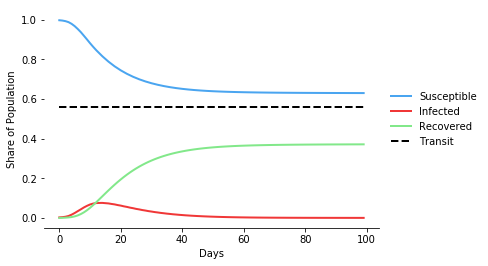

In [13]:
ptv = generate_ptv(public_trans=0.56, days=100, scenario='1')
args1 = parser.parse_args(f'--randomize 4 --public-trans-vec {ptv} --loading 0'.split())
covid_serial_sim(args1)

100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


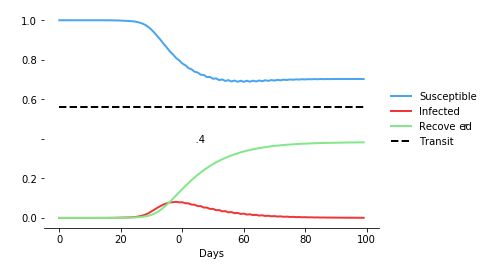

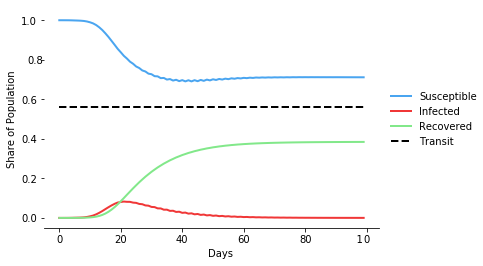

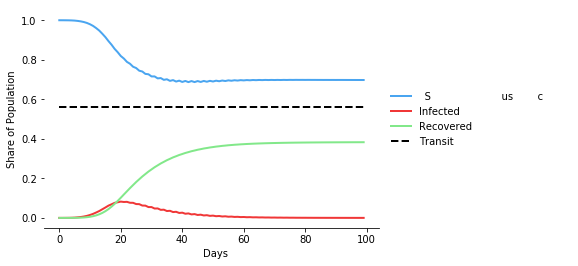

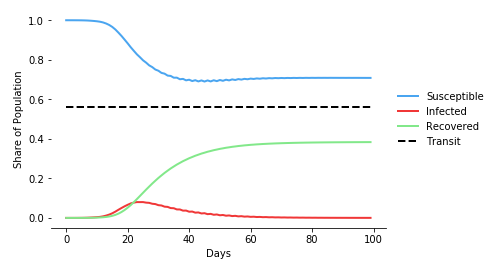

In [20]:
ptv = generate_ptv(public_trans=0.56, days=100, scenario='1')
args1 = parser.parse_args(f'--randomize 4 --public-trans-vec {ptv} --loading 0'.split())
multiprocess(args1)

In [56]:
parser = argparse.ArgumentParser(description='COVID Simulator')
parser.add_argument('--randomize', type=int, default=0)
parser.add_argument('--origin-matrix-path', default='data/nyc_od.csv')
parser.add_argument('--thresh1', type=int, default=0)
parser.add_argument('--thresh2', type=int, default=100)
parser.add_argument('--infection-magnitude', type=int, default=10)
parser.add_argument('--beta', type=float, default=0.75)
parser.add_argument('--gamma', type=float, default=0.2)
parser.add_argument('--public-trans', type=float, default=0.56)
parser.add_argument('--public-trans-vec', nargs='+', default=[])
parser.add_argument('--days', type=int, default=100)
parser.add_argument('--img-folder', default='figures/')
parser.add_argument('--loading', default = 0)

_StoreAction(option_strings=['--loading'], dest='loading', nargs=None, const=None, default=0, type=None, choices=None, help=None, metavar=None)

In [65]:
args1 = parser.parse_args(f'--randomize 4 --gamma 0.2 --public-trans-vec {ptv}'.split())

In [59]:
%lprun -f covid_sim covid_sim(args1)

AttributeError: 'dict' object has no attribute 'loading'

In [126]:
%lprun -f multiprocess multiprocess(args2)

# Modeling and Experiments

##### Simulation code with cython minus tqdm

In [112]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [140]:
%%cython

# cython: profile=True
# cython: linetrace=True
# cython: binding=True
# distutils: define_macros=CYTHON_TRACE_NOGIL=1

import numpy as np
from tqdm import tqdm
import argparse
from multiprocessing import cpu_count
from functools import partial
from multiprocessing.pool import Pool
import pandas as pd
import feather

# Matplotlib doesn't play nicely with multiprocessing, so
# we have to create a separate graphing function & import matplotlib inside of that.
def graphing_function(args, days, norms):
    import matplotlib.pyplot as plt
    susceptible_pop_norm, infected_pop_norm, recovered_pop_norm = norms
    public_trans_vec = args.public_trans_vec
    if isinstance(public_trans_vec[0], str):
        public_trans_vec = np.asarray([float(i.replace('[', '').replace(',','').replace(']','')) for i in args.public_trans_vec if i not in ['[',']',',',' ']])
    # plot results and save the plot
    fig = plt.figure()
    ax = plt.axes()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.plot(np.arange(days), susceptible_pop_norm, label='Susceptible', color='#4aa5f0', linewidth=2)
    ax.plot(np.arange(days), infected_pop_norm, label='Infected', color='#f03737', linewidth=2)
    ax.plot(np.arange(days), recovered_pop_norm, label='Recovered', color='#82e88a', linewidth=2)
    ax.plot(np.arange(days), public_trans_vec, '--', label='Transit', color='k', linewidth=2)
    ax.legend(frameon=False, loc='center left', bbox_to_anchor=(1.01, 0.5))
    ax.set_xlabel("Days")
    ax.set_ylabel("Share of Population")
    if 'fig_name' in args:
        ax.figure.savefig('figures/' + args.fig_name + '.png')
    else:
        ax.figure.savefig('figures/sir_plot.png')
    plt.show()
    plt.close()
    
# Convenience function: access Python dict keys as dict.key instead of dict['key']
class objdict(dict):
    def __getattr__(self, name):
        if name in self:
            return self[name]
        else:
            raise AttributeError("No such attribute: " + name)

    def __setattr__(self, name, value):
        self[name] = value

    def __delattr__(self, name):
        if name in self:
            del self[name]
        else:
            raise AttributeError("No such attribute: " + name)
            
# Run n simulations in parallel: for each run, parameters are randomly sampled from an interval
# NOTE: Are these intervals reasonable?
def multiprocess(args):

    chunks = []
    num_procs = args.randomize
    for _ in range(num_procs):
        d = dict()
        d['origin_matrix_path'] = args.origin_matrix_path
        d['thresh1'] = np.random.randint(0, 350)
        d['thresh2'] = np.random.randint(d['thresh1'], 700)
        d['infection_magnitude'] = np.random.randint(5, 15)
        d['beta'] = args.beta
        d['gamma'] = args.gamma
        d['public_trans'] = np.random.randint(1, 7) * 0.1
        d['public_trans_vec'] = np.asarray([float(i.replace('[', '').replace(',','').replace(']','')) for i in args.public_trans_vec if i not in ['[',']',',',' ']])
        d['days'] = args.days
        d['fig_name'] = 'public_trans_{:0.1f}_({}, {})_inf_{}'.format(d['public_trans'], d['thresh1'], d['thresh2'], d['infection_magnitude'])
        d['loading'] = args.loading
        d = objdict(d)
        chunks.append(d)

    with Pool(num_procs) as p:
        p.map(covid_sim, chunks)

    p.join()

def covid_sim(args):
    # Read in origin-destination flow matrix
    if int(args.loading) == 0:
        OD = np.genfromtxt(args.origin_matrix_path, delimiter=',')
        
    elif int(args.loading) == 1:
        OD = pd.read_csv('data/nyc_od.csv', header=None, dtype=np.float64).to_numpy()
        
    elif int(args.loading) == 2:
        OD = feather.read_dataframe('data/nyc_od.feather').to_numpy()
    

    # initialize the population vector from the origin-destination flow matrix
    N_k = np.abs(np.diagonal(OD) + OD.sum(axis=0) - OD.sum(axis=1))
    locs_len = len(N_k)                 # number of locations
    SIR = np.zeros(shape=(locs_len, 3)) # make a numpy array with 3 columns for keeping track of the S, I, R groups
    SIR[:,0] = N_k                      # initialize the S group with the respective populations
    thresh1 = args.thresh1
    thresh2 = args.thresh2

    first_infections = np.where((thresh1 <= SIR[:, 0]) & (SIR[:, 0] <= thresh2), np.random.randint(1, args.infection_magnitude), 0)   # for demo purposes, randomly introduce infections
    # NOTE: this is arbitrary but not actually random.... 
    SIR[:, 0] = SIR[:, 0] - first_infections
    SIR[:, 1] = SIR[:, 1] + first_infections                           # move infections to the I group

    # row normalize the SIR matrix for keeping track of group proportions
    row_sums = SIR.sum(axis=1)
    SIR_n = SIR / row_sums[:, np.newaxis]

    # initialize parameters
    beta = args.beta
    gamma = args.gamma
    public_trans = args.public_trans                                 # alpha
    R0 = beta/gamma
    beta_vec = np.random.gamma(beta, 2, locs_len)
    gamma_vec = np.full(locs_len, gamma)
    public_trans_vec = args.public_trans_vec
    if isinstance(public_trans_vec[0], str):
        public_trans_vec = np.asarray([float(i.replace('[', '').replace(',','').replace(']','')) for i in args.public_trans_vec if i not in ['[',']',',',' ']])
#     print(type(public_trans_vec[0]))
#     print(public_trans_vec)

    # make copy of the SIR matrices 
    SIR_sim = SIR.copy()
    SIR_nsim = SIR_n.copy()

    # run model
    #print(SIR_sim.sum(axis=0).sum() == N_k.sum())
    infected_pop_norm = []
    susceptible_pop_norm = []
    recovered_pop_norm = []
    days = args.days
    for time_step in range(days):
        infected_mat = np.array([SIR_nsim[:,1],]*locs_len).transpose()
        OD_infected = np.round(OD*infected_mat)
        inflow_infected = OD_infected.sum(axis=0)
        inflow_infected = np.round(inflow_infected*public_trans_vec[time_step])
        #print('total infected inflow: ', inflow_infected.sum())
        new_infect = beta_vec*SIR_sim[:, 0]*inflow_infected/(N_k + OD.sum(axis=0))
        new_recovered = gamma_vec*SIR_sim[:, 1]
        new_infect = np.where(new_infect>SIR_sim[:, 0], SIR_sim[:, 0], new_infect)
        SIR_sim[:, 0] = SIR_sim[:, 0] - new_infect
        SIR_sim[:, 1] = SIR_sim[:, 1] + new_infect - new_recovered
        SIR_sim[:, 2] = SIR_sim[:, 2] + new_recovered
        SIR_sim = np.where(SIR_sim<0,0,SIR_sim)
        # recompute the normalized SIR matrix
        row_sums = SIR_sim.sum(axis=1)
        SIR_nsim = SIR_sim / row_sums[:, np.newaxis]
        S = SIR_sim[:,0].sum()/N_k.sum()
        I = SIR_sim[:,1].sum()/N_k.sum()
        R = SIR_sim[:,2].sum()/N_k.sum()
        #print(S, I, R, (S+I+R)*N_k.sum(), N_k.sum())
        #print('\n')
        infected_pop_norm.append(I)
        susceptible_pop_norm.append(S)
        recovered_pop_norm.append(R)

    graphing_function(args, days, (susceptible_pop_norm, infected_pop_norm, recovered_pop_norm))

def covid_sim_serial(args):
    for i in range(args.randomize):
        covid_sim(args)

In [10]:
parser = argparse.ArgumentParser(description='COVID Simulator')
parser.add_argument('--randomize', type=int, default=0)
parser.add_argument('--origin-matrix-path', default='data/nyc_od.csv')
parser.add_argument('--thresh1', type=int, default=0)
parser.add_argument('--thresh2', type=int, default=100)
parser.add_argument('--infection-magnitude', type=int, default=10)
parser.add_argument('--beta', type=float, default=0.75)
parser.add_argument('--gamma', type=float, default=0.2)
parser.add_argument('--public-trans', type=float, default=0.56)
parser.add_argument('--public-trans-vec', nargs='+', default=[])
parser.add_argument('--days', type=int, default=100)
parser.add_argument('--img-folder', default='figures/')
parser.add_argument('--loading', default = 0)
parser.add_argument('--fig-name', default = 'figure_1')

_StoreAction(option_strings=['--fig-name'], dest='fig_name', nargs=None, const=None, default='figure_1', type=None, choices=None, help=None, metavar=None)

In [34]:
ptv = generate_ptv(public_trans=0.56, days=100, scenario='1')
args1 = parser.parse_args(f'--randomize 4 --loading 2 --public-trans-vec {ptv}'.split())
covid_serial_sim(args1)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.40it/s]


### Estimating public_trans_vec

56% of the population of NYC uses the public transportation system. Thus, we initially set public_trans 
to 0.56. The earliest reported symptoms of a confirmed case occurred on Feb 22nd, and we estimate that the 
individual was infected 5 days prior (Feb 17th). This will mark the first day of our simulation, although 
there were likely infections prior to this date, since the infected individual did not travel anywhere 
prior to contracting the virus. NYC limited transportation of non-essential workers on March 22nd, 34 days 
later. This is reflected by lowering the public_trans value on the 34th day of the simulation. 
Reports from the MTA have stated that from February, subway ridership fell by 60% as of 
March 17th, and 92% by April 8th, and 93% by April 17th. We can use these values to estimate public_trans 
over time. <br><br>


#### Timeline
Day &emsp; Ridership <br>
1 &emsp;&emsp;&nbsp;  100% <br>
19 &emsp;&emsp;100% (March 7th -- state of emergency declared -- this is when ridership likely started falling) <br>
29 &emsp;&emsp; 40% (March 17th) <br>
51 &emsp;&emsp; 8%  (Aprile 8th) <br>
60 &emsp;&emsp; 7%  (April 17th) <br>
88 &emsp;&emsp; 28%  (May 15th -- possible lifting of stay-at-home restrictions) <br>
<br>
Sources: <br>
https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_New_York_(state)#Timeline <br>
https://nytransit.org/resources/public-transit-facts <br>
https://comptroller.nyc.gov/reports/new-york-citys-frontline-workers/<br>
http://web.mta.info/nyct/facts/ridership/ <br>
https://www.businessinsider.com/coronavirus-nyc-subway-ridership-craters-amid-coronavirus-mta-seeks-bailout-2020-3 <br>
https://www.businessinsider.com/new-york-subway-rides-plunge-mta-requests-second-bailout-93-2020-4 <br>
https://brooklyneagle.com/articles/2020/04/08/new-york-city-subway-ridership-down-92-percent-due-to-coronavirus/

#### MTA ridership over time

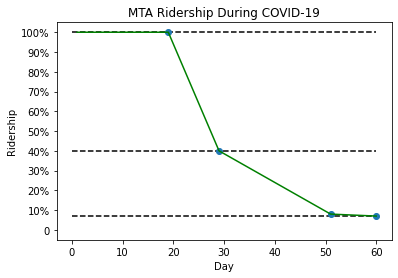

In [70]:
# approximate ridership percentages over time 
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
%matplotlib inline

earlier_start = 0    # in days before Feb 22 (day of Patient-0's first reported symptoms)
earlier_shutdown = 0 # in days before travel restrictions take effect
x = [19+earlier_start-earlier_shutdown, 29+earlier_start-earlier_shutdown, 51+earlier_start-earlier_shutdown, 60+earlier_start-earlier_shutdown]
y = [1, .4, .08, .07]
f = interp1d(x, y)
plt.plot(x, y, 'o')
plt.xlabel('Day')
plt.ylabel('Ridership')
new_y = np.append([1], f(x))
x = np.append([1], x)
plt.plot(x, new_y, 'g', '-')
plt.yticks(np.arange(0,1.1, step=0.1), ['0','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%'])
plt.hlines([1, .4, .07], 0, 60+earlier_start, linestyles='--')
plt.title('MTA Ridership During COVID-19')
plt.show()

In [6]:
# function to generate public_trans_vec
def generate_ptv(public_trans=0.56, earlier_start=0, earlier_shutdown=0, days=100, low_val=0.07, earlier_decline=0, reopen_day=88, reopen_val=0.07, scenario=None, plot=False):
    '''
    earlier_start : shifting the start of infections (days before Feb 22--day of Patient-0's first reported symptoms)
    earlier_shutdown : shifting the decrease in transit (days before March 7th--state of emergency declared)
    public_trans : baseline % of population using public transit during normal times
    days : days to run simulation for
    '''  
    # scenario 1: constant transit
    if scenario == '1':
        return np.full(days, public_trans)
    
    # scenario 2: transit decreases and stays low
    if scenario == '2':
        x = [19+earlier_start-earlier_shutdown, 29+earlier_start-earlier_shutdown, 51-earlier_decline+earlier_start-earlier_shutdown]
        y = [1, .4, low_val]
        f = interp1d(x, y)
        # append values for days before and after periods of decreasing ridership
        ridership = np.append(np.ones(18+earlier_start-earlier_shutdown), f(np.arange(19+earlier_start-earlier_shutdown,52-earlier_decline+earlier_start-earlier_shutdown)))
        ridership = np.append(ridership, np.full(days-len(ridership), low_val))
        # multiply ridership by public_trans to get public_trans_vec, append to reopen_vals
        public_trans_vec = ridership * public_trans
        return public_trans_vec
          
    # scenario 3: transit decreases and then increases when retrictions are lifted
    if scenario == '3':
        x = [19+earlier_start-earlier_shutdown, 29+earlier_start-earlier_shutdown, 51+earlier_start-earlier_shutdown, 60+earlier_start-earlier_shutdown]
        y = [1, .4, .08, low_val]
        f = interp1d(x, y)
        # append values for days before and after periods of decreasing ridership
        ridership = np.append(np.ones(18+earlier_start-earlier_shutdown), f(np.arange(19+earlier_start-earlier_shutdown,61+earlier_start-earlier_shutdown)))
        ridership = np.append(ridership, np.full(days-len(ridership), reopen_val))
        # multiply ridership by public_trans to get public_trans_vec, append to reopen_vals
        public_trans_vec = ridership * public_trans
        return public_trans_vec
    
#     if plot:
#         plt.plot(np.arange(0,days), public_trans_vec)
#         plt.xlabel('Day')
#         plt.ylabel('Ridership')
#         plt.title('Percent of New Yorkers using MTA')
#         plt.show()

### Scenario 1: travel stays constant

transit = 0.56


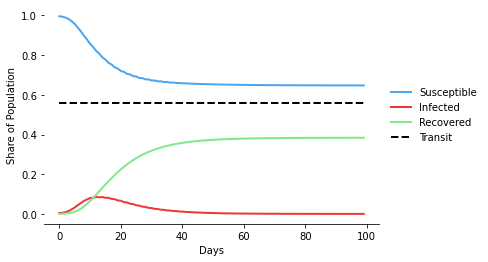

In [132]:
# constant transit at 0.56
print('medium transit level (0.56)')
ptv = generate_ptv(public_trans=0.56, days=100, scenario='1')
args1 = parser.parse_args(f'--randomize 4 --loading 2 --public-trans-vec {ptv}'.split())
covid_sim(args1)

transit = 0.80


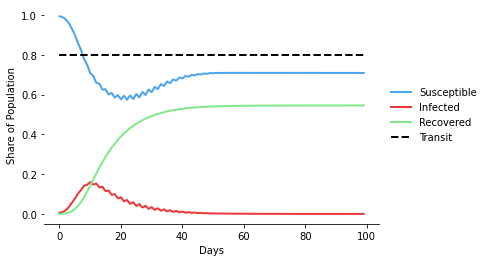

In [133]:
# high constant transit at 0.8
print('high transit level (0.80)')
ptv = generate_ptv(public_trans=0.8, scenario='1')
args1 = parser.parse_args(f'--randomize 4 --loading 2 --public-trans-vec {ptv}'.split())
covid_sim(args1)

transit = 0.25


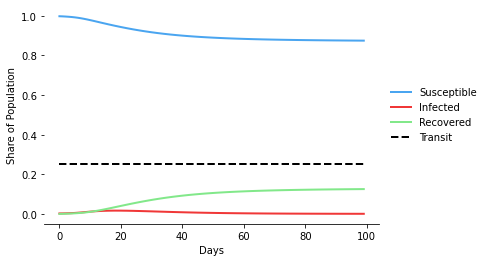

In [134]:
# low constant transit at 0.25
print('low transit level (0.25)')
ptv = generate_ptv(public_trans=0.25, days=100, scenario='1')
args1 = parser.parse_args(f'--randomize 4 --loading 2 --public-trans-vec {ptv}'.split())
covid_sim(args1)

### Scenario 2: travel decreases and stays low

transit decreases to 0.07


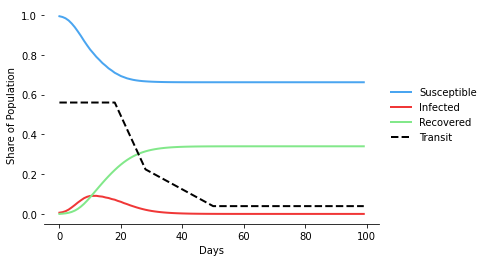

In [166]:
print('transit decreases to 0.07')
ptv = generate_ptv(public_trans=0.56, low_val=0.07, scenario='2')
args2 = parser.parse_args(f'--randomize 4 --loading 2 --public-trans-vec {ptv}'.split())
covid_sim(args2)

transit decreases to 0.14


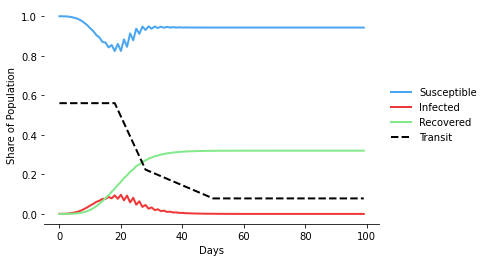

In [167]:
print('transit decreases to 0.14')
ptv = generate_ptv(public_trans=0.56, low_val=0.14, scenario='2')
args2 = parser.parse_args(f'--randomize 4 --loading 2 --public-trans-vec {ptv}'.split())
covid_sim(args2)

transit decreases to 0


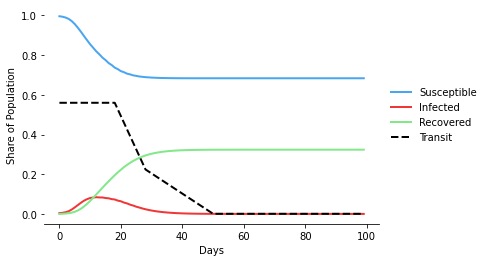

In [163]:
print('transit decreases to 0')
ptv = generate_ptv(public_trans=0.56, low_val=0.001, scenario='2')
args2 = parser.parse_args(f'--randomize 4 --loading 2 --public-trans-vec {ptv}'.split())
covid_sim(args2)

transit decreases more rapidly to 0


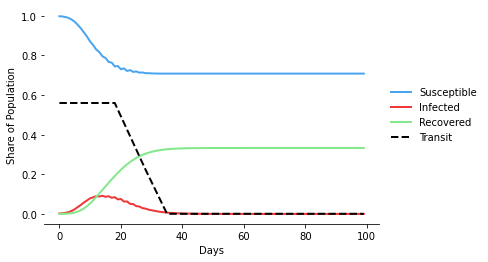

In [165]:
print('transit decreases more rapidly to 0')
ptv = generate_ptv(public_trans=0.56, low_val=0.001, earlier_decline=15, scenario='2')
args2 = parser.parse_args(f'--randomize 4 --loading 2 --public-trans-vec {ptv}'.split())
covid_sim(args2)

#### Scenario 3: NYC reopens on May 15th and transit increases 

NYC reopens, transit goes to 0.28


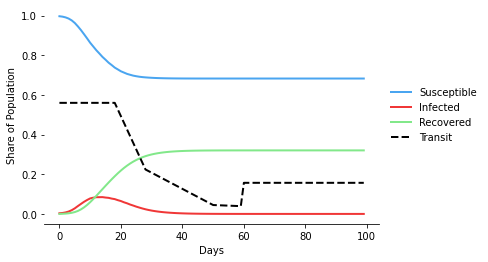

In [170]:
print('NYC reopens, transit goes to 0.28')
ptv = generate_ptv(public_trans=0.56, reopen_val=0.28, scenario='3')
args3 = parser.parse_args(f'--randomize 4 --loading 2 --public-trans-vec {ptv}'.split())
covid_sim(args3)

NYC reopens, transit goes to 0.56


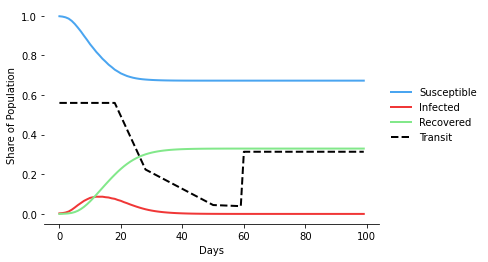

In [171]:
print('NYC reopens, transit goes to 0.56')
ptv = generate_ptv(public_trans=0.56, reopen_val=0.56, scenario='3')
args3 = parser.parse_args(f'--randomize 4 --loading 2 --public-trans-vec {ptv}'.split())
covid_sim(args3)